In [76]:
import numpy as np
from scipy.optimize import minimize
import csv
import random
import matplotlib.pyplot as plt
import copy
import math

In [167]:
parkingLotSize = 173
# chargingProbability = 0.25 #REMOVE
installCost = 1000
rebatePercent = 0.5 #Assuming that we will get 100% of all rebates applied for
hydroPrice = 1.25 #Dollars per kWhour - FILLER NOT REAL VALUE
markup = 0.15 #Dollars per kWhour
weeks = 522 #10 years
batteryEnergy = 57 #kWh, small SUV, BEV200, 2015
batteryPower = 157 #kW, small SUV, BEV200, 2015

In [78]:
# Open the CSV file
csv_file = open('time_demand.csv', 'r')
csv_file2 = open('vehicle_registration_2022.csv', 'r')
csv_file3 = open('rebates.csv', 'r')

# Create a csv.reader object
csv_reader = csv.reader(csv_file)
csv_reader2 = csv.reader(csv_file2)
csv_reader3 = csv.reader(csv_file3)

# Initialize an empty array to store the CSV data
data_array = []
data_array2 = []
data_array3 = []

# Read and store data row by row
for row in csv_reader:
    data_array.append(row)
for row in csv_reader2:
    data_array2.append(row)
for row in csv_reader3:
    data_array3.append(row)

# Close the CSV file
csv_file.close()
csv_file2.close()
csv_file3.close()

demandHourly = [item for sublist in [row[1:] for row in data_array[1:-1]] for item in sublist]
vehicleRegistration2022 = data_array2
rebates = data_array3

In [79]:
#Need a script that calculates percent of vehicles in area that are EVs based on vehicle registration data
#Defines variable percentEV

# Specify the column index you want to analyze
column_index = 3  # 3 corresponds to EV included
target_text = "Yes"
count_matches = 0

# Iterate through the rows and check for matches
for row in vehicleRegistration2022[1:]:  # Skip the header row
    if row[column_index] == target_text:
        count_matches += 1

# Calculate the percentage
total_rows = len(vehicleRegistration2022) - 1  # Subtract 1 to exclude the header row
percentEV = count_matches / total_rows
percentEV

0.03045657988467897

In [102]:
def chargingDemand(demandHourly,percentEV,chargerCount,parkingLotSize):
    #Takes inputs: array demandHourly which is 13 (hours per day) by 7 (days per week), float percentEV, float chargingProbability
    #Returns total number of charging instances per week weeklyChargeCount
    
    chargerCount = round(chargerCount)
    weeklyChargeCount = 0
    randomCarArray = []
    chargers = [[False,"",""]]*chargerCount
    chargersFilled = [chargers]
    falses = []
    chargersOccupied = 0
    for i in demandHourly:
        
        parkingSpots = [False,"",""]*(173 - chargerCount)
        chargers = sorted(chargers, key=lambda x: not x[0])
        
        #Cars leaving/staying at chargers:
        for k, car in enumerate(chargers):
            if car[0] and car[2] >= 100:
                chargers[k] = [False,"",""]
                chargersOccupied -= 1
            #ASSUMING CAR CHARGES TO 100%
            elif car[0] and car[2] < 100:
                #car will charge (ASSUMING 20% PER HOUR - CORRECT LATER)
                chargers[k][2] += 20
                
        #Sort chargers so filled comes first
        chargers = sorted(chargers, key=lambda x: not x[0])
                
        for j, car in enumerate(parkingSpots):
            randomCar = generateCar(float(i),percentEV)
            randomCarArray.append(randomCar)
            #if random car is EV that wants to charge:
            if randomCar[1] and randomCar[2] < 40 and chargersOccupied < chargerCount:
                #car will charge (ASSUMING 20% PER HOUR - CORRECT LATER)
                randomCar[2] += 20
                #car parks in charger spot
                chargers = sorted(chargers, key=lambda x: not x[0])
                chargers[chargersOccupied] = randomCar
                chargersOccupied += 1
            else:
                #car parks in regular spot
                parkingSpots[j] = randomCar
                
        chargersFilled.append(copy.deepcopy(chargers))
        
        weeklyChargeCount += chargersOccupied
    return(weeklyChargeCount,chargersFilled)


In [81]:
def generateCar(demand,percentEV):
    #generates a Car: array of length 3 [does the car exist?,is the car an EV?,SOC]
    #to do: add additional car properties
    #if the spot is empty (random number is above % chance that spot is filled)
    car = [False,"",""]
    if random.randint(1, 100) > (demand*100):
        return car
    #if car is EV
    elif random.randint(1, 100) < (percentEV*100):
        car[0] = True
        car[1] = True
        car[2] = random.randint(20, 80)
    else:
        car[0] = True
        car[1] = False
    
    return car

# counttest = 100
# test = []
# while counttest > 0:
#     test.append(generateCar(0.5,0.1))
#     counttest -= 1
# test

In [82]:
chargingDemand(demandHourly,percentEV,3,parkingLotSize)[0]

262

In [164]:
def powerToHour(markup,power):
    #Calculates the price per hour based on price per kWh
    priceHour = markup*power #$/kWh * kW = $/h
    return(priceHour)

#NOTE: Charger quote is from Chargepoint and is currently hardcoded into the function below (change this later):

In [168]:
def profit(installCost,rebatePercent,weeks,demandHourly,percentEV,chargers,parkingLotSize,markup,power):
    #Takes inputs: float installCost in CAD, float rebatePercent, chargeCharge in CAD/hour (change this eventually to CAD/kWh and weeklyChargeCount to kwH/week)
    #plus params for ChargingDemand
    hourlyPrice = powerToHour(markup,power)
    revenue = 0
    revenueWeekly = []
    if power <= 7.2:
        chargerCost = 11500
    elif 7.2 < power <= 20:
        chargerCost = 18000
    else:
        chargerCost = 40000
    costsBeforeRebate = (installCost+chargerCost)*chargers
    [rebateAmount,rebateMax] = rebate(float(power))
    if costsBeforeRebate*(1-rebateAmount)*rebatePercent > rebateMax:
        costs = costsBeforeRebate-rebateMax
    else:
        costs = costsBeforeRebate * (rebateAmount/rebatePercent)
    #This needs to be adjusted for inflation later
    while weeks > 0:
        weekRevenue = chargingDemand(demandHourly,percentEV,chargers,parkingLotSize)[0] * hourlyPrice
        revenue += weekRevenue
        revenueWeekly.append(revenue)
        weeks -= 1
        print(weeks)
    return(revenue-costs,revenueWeekly,costs,costsBeforeRebate)
    #Returns total profit/loss in CAD

In [85]:
def rebate(power):
    #Based on charger power, returns maximum rebate percentage and maximum rebate in dollars
    percentPaid = 1
    rebateMax = 0
    usedRebate = ""
    for i in rebates[1:]:
        if i[0] != usedRebate and (float(i[1]) >= float(power)) and (float(power) <= float(i[2])):
            usedRebate = i[0]
            percentPaid *= (1-float(i[3]))
            rebateMax += float(i[4])
    return(percentPaid,rebateMax)

In [86]:
def EVDemandIncrease(markup,chargers):
    #returns the % increase in EV sales given electricity price markup and number of chargers installed
    coeffs = {
        1:[0.1997,-0.032]
        ,2:[0.1997,-0.032]
        ,3:[0.1997,-0.032]
        ,4:[0.2193,-0.031]
        ,5:[0.2193,-0.031]
        ,6:[0.2193,-0.031]
        ,7:[0.227,-0.028]
        ,8:[0.227,-0.028]
        ,9:[0.227,-0.028]
        ,10:[0.2325,-0.027]
        ,11:[0.2325,-0.027]
        ,12:[0.236,-0.026]
        ,13:[0.236,-0.026]
        ,14:[0.2405,-0.025]
        ,15:[0.2405,-0.025]
        ,16:[0.2405,-0.025]
    }
    return(coeffs[chargers][0]*math.exp(coeffs[chargers][1]*markup))
    

In [172]:
def chargerSizing(installCost,rebatePercent,weeks,demandHourly,percentEV,parkingLotSize,markup):
    #This is an optimization function that finds the optimal number of chargers to maximize profit
    defaultChargers = 1
    defaultPower = 20
    
    def profitMin(vars):
        x = vars[0]
        y = vars[1]
        return(-profit(installCost,rebatePercent,weeks, demandHourly,percentEV,x,parkingLotSize,markup, y)[0])
    
    bnds = [(1,16),(7,100)]
    result = minimize(profitMin, [defaultChargers,defaultPower], bounds=bnds)
    chargers = result.x[0]
    power = result.x[1]
    netprofit = -result.fun
    return(chargers, power)

In [173]:
chargerSizing(installCost,rebatePercent,weeks,demandHourly,percentEV,parkingLotSize,hourlyPrice)

521
520
519
518
517
516
515
514
513
512
511
510
509
508
507
506
505
504
503
502
501
500
499
498
497
496
495
494
493
492
491
490
489
488
487
486
485
484
483
482
481
480
479
478
477
476
475
474
473
472
471
470
469
468
467
466
465
464
463
462
461
460
459
458
457
456
455
454
453
452
451
450
449
448
447
446
445
444
443
442
441
440
439
438
437
436
435
434
433
432
431
430
429
428
427
426
425
424
423
422
421
420
419
418
417
416
415
414
413
412
411
410
409
408
407
406
405
404
403
402
401
400
399
398
397
396
395
394
393
392
391
390
389
388
387
386
385
384
383
382
381
380
379
378
377
376
375
374
373
372
371
370
369
368
367
366
365
364
363
362
361
360
359
358
357
356
355
354
353
352
351
350
349
348
347
346
345
344
343
342
341
340
339
338
337
336
335
334
333
332
331
330
329
328
327
326
325
324
323
322
321
320
319
318
317
316
315
314
313
312
311
310
309
308
307
306
305
304
303
302
301
300
299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272


448
447
446
445
444
443
442
441
440
439
438
437
436
435
434
433
432
431
430
429
428
427
426
425
424
423
422
421
420
419
418
417
416
415
414
413
412
411
410
409
408
407
406
405
404
403
402
401
400
399
398
397
396
395
394
393
392
391
390
389
388
387
386
385
384
383
382
381
380
379
378
377
376
375
374
373
372
371
370
369
368
367
366
365
364
363
362
361
360
359
358
357
356
355
354
353
352
351
350
349
348
347
346
345
344
343
342
341
340
339
338
337
336
335
334
333
332
331
330
329
328
327
326
325
324
323
322
321
320
319
318
317
316
315
314
313
312
311
310
309
308
307
306
305
304
303
302
301
300
299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
269
268
267
266
265
264
263
262
261
260
259
258
257
256
255
254
253
252
251
250
249
248
247
246
245
244
243
242
241
240
239
238
237
236
235
234
233
232
231
230
229
228
227
226
225
224
223
222
221
220
219
218
217
216
215
214
213
212
211
210
209
208
207
206
205
204
203
202
201
200
199


377
376
375
374
373
372
371
370
369
368
367
366
365
364
363
362
361
360
359
358
357
356
355
354
353
352
351
350
349
348
347
346
345
344
343
342
341
340
339
338
337
336
335
334
333
332
331
330
329
328
327
326
325
324
323
322
321
320
319
318
317
316
315
314
313
312
311
310
309
308
307
306
305
304
303
302
301
300
299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
269
268
267
266
265
264
263
262
261
260
259
258
257
256
255
254
253
252
251
250
249
248
247
246
245
244
243
242
241
240
239
238
237
236
235
234
233
232
231
230
229
228
227
226
225
224
223
222
221
220
219
218
217
216
215
214
213
212
211
210
209
208
207
206
205
204
203
202
201
200
199
198
197
196
195
194
193
192
191
190
189
188
187
186
185
184
183
182
181
180
179
178
177
176
175
174
173
172
171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
152
151
150
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128


KeyboardInterrupt: 

In [174]:
options = [[2,7.2],[2,20]
          ,[4,7.2],[4,20]
          ,[6,7.2],[6,20]
          ,[8,7.2],[8,20]]
revenueWeekly = []
for i in options:
    revenueWeekly.append([profit(installCost,rebatePercent,weeks,demandHourly,percentEV,i[0],parkingLotSize,markup,i[1])])

521
520
519
518
517
516
515
514
513
512
511
510
509
508
507
506
505
504
503
502
501
500
499
498
497
496
495
494
493
492
491
490
489
488
487
486
485
484
483
482
481
480
479
478
477
476
475
474
473
472
471
470
469
468
467
466
465
464
463
462
461
460
459
458
457
456
455
454
453
452
451
450
449
448
447
446
445
444
443
442
441
440
439
438
437
436
435
434
433
432
431
430
429
428
427
426
425
424
423
422
421
420
419
418
417
416
415
414
413
412
411
410
409
408
407
406
405
404
403
402
401
400
399
398
397
396
395
394
393
392
391
390
389
388
387
386
385
384
383
382
381
380
379
378
377
376
375
374
373
372
371
370
369
368
367
366
365
364
363
362
361
360
359
358
357
356
355
354
353
352
351
350
349
348
347
346
345
344
343
342
341
340
339
338
337
336
335
334
333
332
331
330
329
328
327
326
325
324
323
322
321
320
319
318
317
316
315
314
313
312
311
310
309
308
307
306
305
304
303
302
301
300
299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272


449
448
447
446
445
444
443
442
441
440
439
438
437
436
435
434
433
432
431
430
429
428
427
426
425
424
423
422
421
420
419
418
417
416
415
414
413
412
411
410
409
408
407
406
405
404
403
402
401
400
399
398
397
396
395
394
393
392
391
390
389
388
387
386
385
384
383
382
381
380
379
378
377
376
375
374
373
372
371
370
369
368
367
366
365
364
363
362
361
360
359
358
357
356
355
354
353
352
351
350
349
348
347
346
345
344
343
342
341
340
339
338
337
336
335
334
333
332
331
330
329
328
327
326
325
324
323
322
321
320
319
318
317
316
315
314
313
312
311
310
309
308
307
306
305
304
303
302
301
300
299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
269
268
267
266
265
264
263
262
261
260
259
258
257
256
255
254
253
252
251
250
249
248
247
246
245
244
243
242
241
240
239
238
237
236
235
234
233
232
231
230
229
228
227
226
225
224
223
222
221
220
219
218
217
216
215
214
213
212
211
210
209
208
207
206
205
204
203
202
201
200


In [176]:
print(revenueWeekly)

[[(97960.96000000027, [194.4, 383.4, 569.16, 760.3199999999999, 951.48, 1144.8, 1333.8, 1520.6399999999999, 1713.9599999999998, 1902.9599999999998, 2096.2799999999997, 2289.6, 2474.2799999999997, 2663.2799999999997, 2850.12, 3043.44, 3234.6, 3426.84, 3613.6800000000003, 3808.0800000000004, 3999.2400000000002, 4191.4800000000005, 4380.4800000000005, 4571.64, 4762.8, 4949.64, 5139.72, 5329.8, 5523.12, 5708.88, 5897.88, 6090.12, 6274.8, 6463.8, 6652.8, 6843.96, 7031.88, 7216.56, 7402.320000000001, 7590.240000000001, 7781.400000000001, 7962.84, 8152.92, 8339.76, 8530.92, 8724.24, 8916.48, 9099.0, 9288.0, 9481.32, 9672.48, 9857.16, 10049.4, 10236.24, 10414.44, 10606.68, 10797.84, 10981.44, 11167.2, 11355.12, 11546.28, 11735.28, 11925.36, 12117.6, 12304.44, 12497.76, 12691.08, 12881.16, 13071.24, 13257.0, 13447.08, 13640.4, 13821.84, 14011.92, 14205.24, 14395.32, 14586.48, 14779.8, 14969.88, 15158.88, 15344.64, 15537.96, 15725.88, 15917.039999999999, 16109.279999999999, 16301.519999999999, 1

274085.0
38000


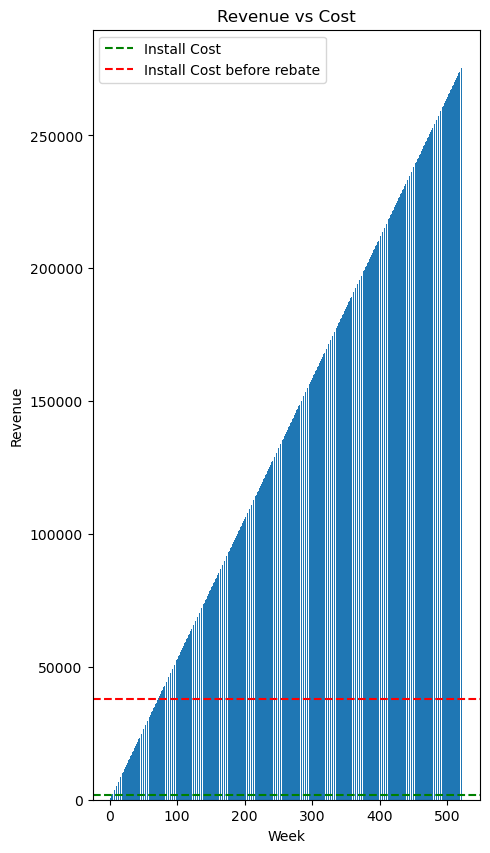

In [170]:
print(revenueWeekly[0])
print(revenueWeekly[3])
# Create the bar graph with position-based labels
plt.figure(figsize=(5, 10))
plt.bar(range(1, len(revenueWeekly[1]) + 1), revenueWeekly[1])

# Add a horizontal line at y=installCost
plt.axhline(y=revenueWeekly[2], color='green', linestyle='--', label='Install Cost')
plt.axhline(y=revenueWeekly[3], color='red', linestyle='--', label='Install Cost before rebate')

# Set the title and labels for the axes
plt.title('Revenue vs Cost')
plt.xlabel('Week')
plt.ylabel('Revenue')

# Display the legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
#num = number of chargers, char_type = charger type (1=[0],2=[1],3=[2]),power_cons = KW consumption of each charger, years 
import numpy as np
type_still_bank = [150,200,300]
type_wear_bank = [0.02,0.03,0.04]
def sustain_func(num,char_type,power_cons,years=10):
    if num != len(char_type):
        print("sustain_func: num and type are not the same len")
    elif num != len(char_type):
        print("sustain_func: num and power_cons are not the same len")
    else:
        seasons = years * 4
        type_still_act = np.zeros([len(type_still_bank),seasons])
        type_wear_act = np.zeros([len(type_wear_bank),seasons])
        adjust_factor = np.array([1,1.1,1.4,1.1])
        for i in range(len(char_type)):
            for j in range(seasons):
                season_index = j%4
                type_still_act[i,j] = type_still_bank[i]*adjust_factor[season_index]
                type_wear_act[i,j] = type_wear_bank[i]*adjust_factor[season_index]
                #if 0,4,8,12 its summer
                #if 1,5,9,13 its fall
                #if 2,6, 10,14 its winter
                #if 3,7,11,15 its spring    
        cost_total = sum(type_still_act)+sum(type_wear_act)
    return(sum(cost_total))
          
print(sustain_func(3,[1,2,1],[100,200,150],years=10))   